# データセットの準備
DAY2で使用したデータセットを準備する

In [1]:
# 必要ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [2]:
# データの読み込み
df_kick_org = pd.read_csv('./data/ks-projects-201801.csv')

In [3]:
# stateがsuccessfulまたはfailedとなるレコードの抽出
df_kick = df_kick_org.loc[(df_kick_org['state'] == 'successful') | (df_kick_org['state'] == 'failed'), :]

df_kick.loc[df_kick['state'] == 'failed', 'state'] = 0
df_kick.loc[df_kick['state'] == 'successful', 'state'] = 1

C:\Users\reneu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# nameの頻出単語から説明変数を作る

In [4]:
# nameの欠損値を埋める
df_kick.loc[:, 'name'] = df_kick['name'].fillna('')
df_kick.isnull().sum()

ID                    0
name                  0
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

# 頻出単語Top50を確認

In [5]:
words_array = []

def extend_array(array):
    words_array.extend(array)

df_kick['name'].str.split().apply(extend_array)

df_words = pd.DataFrame({'words': words_array})

In [6]:
df_words['words'].value_counts().head(50)

The            55291
-              47128
the            30417
of             29602
A              25713
and            21010
a              18517
for            17296
&              15679
to             14844
in             12185
by              7840
New             7798
Project         7655
Album           6654
Film            6392
with            5769
Book            5539
Art             5217
Game            4955
Help            4699
Music           4677
on              4637
THE             4161
your            3888
Your            3774
First           3553
My              3502
An              3458
new             3361
EP              3198
Debut           3178
Short           3161
from            3157
For             3064
|               3044
at              2985
is              2972
In              2783
an              2783
I               2782
To              2743
film            2662
Documentary     2641
Series          2640
Life            2499
World           2449
Video        

冠詞・前置詞・接続詞・記号・be動詞・一般的な単語を除外する。

## 冠詞
* A / a
* An / an
* The / the

## 前置詞
* Of / of
* In / in
* for
* To / to
* by
* on
* from
* with
* at

## 接続詞
* and
* &

## 記号
* -
* |

## be動詞
* is

## 一般的な単語
* your / Your
* I / My

# 説明変数候補となる単語
* New / new
* Project
* Album / album
* Film / film
* Book
* Game
* Art
* Music
* Help
* First
* Debut
* Short
* Series
* Documentary
* Life
* World
* Video

# 新しいものを指すもの単語をまとめる
以下の単語は新しいものを示しているので、説明変数 ``name_new`` にまとめる。
* New / new
* First
* Debut

In [7]:
df_research = pd.get_dummies(df_kick[['state', 'main_category']])

df_research['name'] = df_kick['name'].str.split()

def contains_words(df, column, words):
    words_array = []

    def extend_array(array):
        # wordsの単語リストが含まれていれば1, そうでなければ0
        words_array.append(0 if set(words).isdisjoint(set(array)) else 1)
        
    df['name'].apply(extend_array)
    df.loc[:, column] = words_array

contains_words(df_research, 'name_new', ['New', 'new', 'Debut', 'debut', 'First', 'first'])
contains_words(df_research, 'name_project', ['Project', 'project'])
contains_words(df_research, 'name_album', ['Album', 'album'])
contains_words(df_research, 'name_firm', ['Film', 'film'])
contains_words(df_research, 'name_book', ['Book', 'book'])
contains_words(df_research, 'name_game', ['Game', 'game'])
contains_words(df_research, 'name_art', ['Art', 'art'])
contains_words(df_research, 'name_music', ['Music', 'music'])
contains_words(df_research, 'name_help', ['Help', 'help'])
contains_words(df_research, 'name_short', ['Short', 'short'])
contains_words(df_research, 'name_series', ['Series', 'series'])
contains_words(df_research, 'name_documentary', ['Documentary', 'documentary'])
contains_words(df_research, 'name_life', ['Life', 'life'])
contains_words(df_research, 'name_world', ['World', 'world'])
contains_words(df_research, 'name_video', ['Video', 'video'])
display(df_research.head())

,state,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,...,name_game,name_art,name_music,name_help,name_short,name_series,name_documentary,name_life,name_world,name_video
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# main_categoryと名前の品質単語の相関
main_categoryの単語がnameの品質単語にも見られる。  
共分散を見て、相関が高ければ説明変数から除外してよさそう。

In [8]:
# main_categoryの登録内容を見てみる
df_kick_org['main_category'].value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

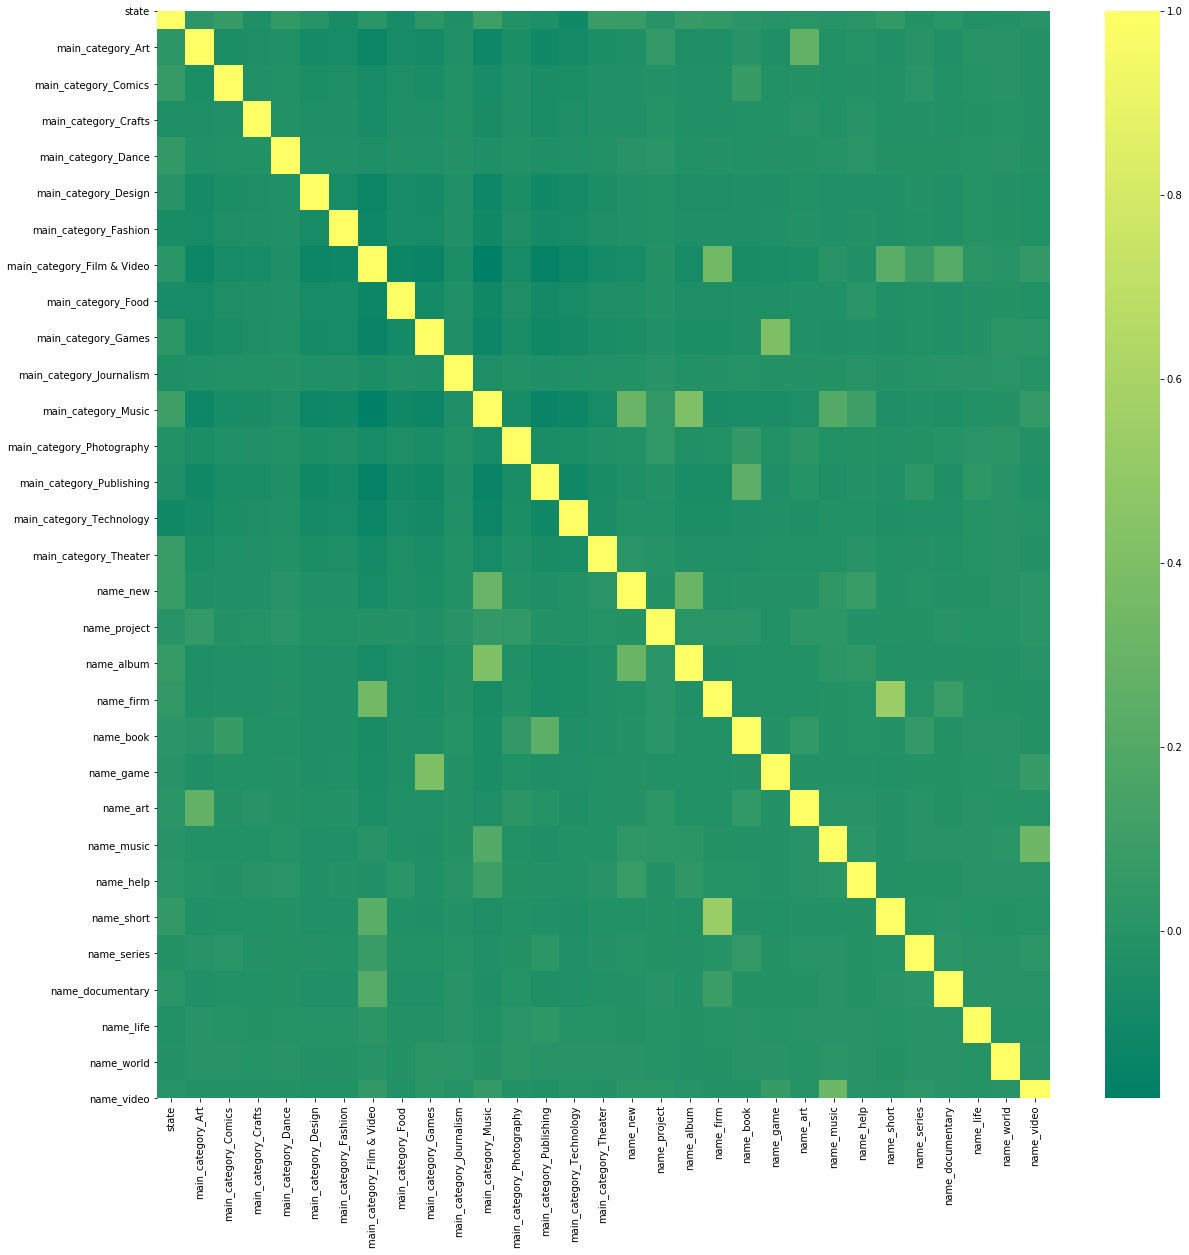

In [9]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_research.corr(), cmap = 'summer')
plt.show()

# stateと相関がありそうな単語
stateと共分散が高い説明変数は以下の3つである。
* name_art
* name_project
* name_book

このうち、``name_book`` は ``main_category_Publishing`` と共分散が高いので、説明変数に含める必要はないと判断する。

nameの単語から新たに説明変数に加えるのは、以下の2つとする。
* name_art
* name_project

# 他の説明変数の整備
DAY2までに実施した前処理を実施した後、nameの単語から加える説明変数を追加する。

In [10]:
# 募集期間periodの作成
df_kick.loc[:, 'deadline_dt'] = pd.to_datetime(df_kick['deadline'])
df_kick.loc[:, 'launched_dt'] = pd.to_datetime(df_kick['launched'])

df_kick.loc[:, 'period_dt'] = df_kick['deadline_dt'] - df_kick['launched_dt']
df_kick.loc[:, 'period'] = df_kick['period_dt'].dt.days

# nameの文字数をname_lengthという説明変数にする
df_kick.loc[:, 'name_length'] = df_kick['name'].str.len()

# name_lengthの欠損値に0を入れる
df_kick.loc[:, 'name_length'] = df_kick['name_length'].fillna(0)

# usd_goal_realを対数変換する
df_kick.loc[:, 'usd_goal_ln'] = np.log10(df_kick.loc[:, 'usd_goal_real'])

# main_category, currencyをone-hot-vector化する
df_kick = pd.get_dummies(df_kick[['state', 'main_category', 'currency', 'usd_goal_ln', 'period', 'name_length']])

# nameの単語から説明変数を加える
df_kick['name_art'] = df_research['name_art'].copy()
df_kick['name_project'] = df_research['name_project'].copy()

display(df_kick.head())

C:\Users\reneu\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


,state,usd_goal_ln,period,name_length,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,name_art,name_project
0,0,3.185811,58,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4.477121,59,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,4.653213,44,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,3.698970,29,49,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,4.698970,34,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# ホールドアウト法で訓練データと検証データに分割
説明変数の標準化は訓練データと検証データに分割する必要がある。  
学習データに検証データの要素が入らないようにすため。(Leakageの防止)

In [11]:
# ホールドアウト法で訓練データと検証データを4:1に分割
from sklearn.model_selection import train_test_split

X_df = df_kick[df_kick.columns[1:]]
y_df = pd.Series(df_kick['state'])

test_size = 0.2

X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(
    X_df, y_df, test_size = test_size, random_state = 1234)

In [12]:
# 説明変数の標準化
import sys
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

# 訓練データの標準化
X_df_train.loc[:, 'usd_goal_ln'] = stdsc.fit_transform(X_df_train[['usd_goal_ln']].values)
X_df_train.loc[:, 'period'] = stdsc.fit_transform(X_df_train[['period']].values)
X_df_train.loc[:, 'name_length'] = stdsc.fit_transform(X_df_train[['name_length']].values)

# 検証データの標準化
X_df_test.loc[:, 'usd_goal_ln'] = stdsc.fit_transform(X_df_test[['usd_goal_ln']].values)
X_df_test.loc[:, 'period'] = stdsc.fit_transform(X_df_test[['period']].values)
X_df_test.loc[:, 'name_length'] = stdsc.fit_transform(X_df_test[['name_length']].values)

C:\Users\reneu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\reneu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\reneu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

# ラッパー法(ステップワイズ法)で特徴選択を行う

In [13]:
from sklearn.feature_selection import RFECV

# L2正則化項のハイパーパラメータはDay2で探索した最適値を利用する
estimator = SGDClassifier(loss = 'log', fit_intercept = True, penalty = 'l2', alpha = 1e-3,
                          random_state = 1234, max_iter = 10000, tol = 1e-3)

# ステップワイズ法＋交差検証法で特徴選択を行う
rfecv = RFECV(estimator, cv = 5, scoring = 'accuracy')

X_train = X_df_train.values
y_train = y_df_train.values

rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=10000, n_iter_no_change=5, n_jobs=None,
                              penalty='l2', power_t=0.5, random_state=1234,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [14]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[ 1  1  1  6  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  4  8  1  1  1
  1 10  1  2  7  9  5  1  3  1]


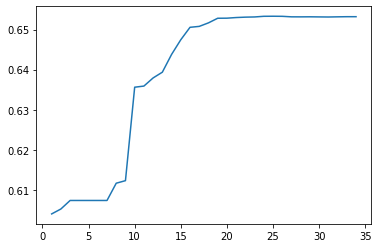

In [15]:
# 特徴数とスコアの変化をプロット
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [16]:
# 削除してもよい特徴量を削除
remove_idx = ~rfecv.support_

remove_feature = X_df_train.columns[remove_idx]
print("削除する特徴量")
print(remove_feature)

X_df_train = X_df_train.drop(remove_feature, axis = 1)
X_df_test = X_df_test.drop(remove_feature, axis = 1)
print("残った特徴量")
print(X_df_train.columns)

削除する特徴量
Index(['main_category_Art', 'currency_CAD', 'currency_CHF', 'currency_JPY',
       'currency_NOK', 'currency_NZD', 'currency_SEK', 'currency_SGD',
       'name_art'],
      dtype='object')
残った特徴量
Index(['usd_goal_ln', 'period', 'name_length', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'currency_AUD', 'currency_DKK', 'currency_EUR',
       'currency_GBP', 'currency_HKD', 'currency_MXN', 'currency_USD',
       'name_project'],
      dtype='object')


# 追加したnameの単語に関する説明変数に関して
``name_art`` が除外変数として選択された。

# 汎化性能を表示する処理を共通関数化しておく

In [17]:
def calc_general_perf(y_est, y_test):
    accuracy = accuracy_score(y_test, y_est)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

    print('正解率 = {:.3f}'.format(accuracy * 100))
    print('適合率(precision) = {:.3f}'.format(precision[1] * 100))
    print('再現率(recall) = {:.3f}'.format(recall[1] * 100))
    print('F1値(F1-score) = {:.3f}'.format(f1_score[1] * 100))

# 特徴選択後のデータで交差検証法を使って訓練性能を確認
交差検証法はDay2の方法ではなく、sckit-learnのcross_val_scoreを使う

In [18]:
from sklearn.model_selection import cross_val_score

n_split = 5 # 分割数

accuracy_total = 0.0
split_num = 1

X_train = X_df_train.values
y_train = y_df_train.values

# ロジスティック回帰モデルで訓練性能を交差検証で算出する
# L2正則化項のハイパーパラメータはDay2で探索した最適値を利用する
clf = SGDClassifier(loss = 'log', fit_intercept = True, penalty = 'l2', alpha = 1e-3,
                    random_state = 1234, max_iter = 10000, tol = 1e-3)
score = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 5)
print("Cross Validation accuracy = {:.3f}".format(score.mean() * 100))

Cross Validation accuracy = 65.331


# 検証データを用いて汎化性能を確認

In [19]:
# ロジスティック回帰モデルを使い、訓練データで学習
clf.fit(X_train, y_train)

X_test = X_df_test.values
y_test = y_df_test.values

# モデルで予測
y_est = clf.predict(X_test)

# 汎化性能を算出
calc_general_perf(y_est, y_test)

正解率 = 65.439
適合率(precision) = 59.945
再現率(recall) = 41.696
F1値(F1-score) = 49.182


# 特徴選択前後の正解率の変化
正解率は少しだけ上昇した。

| 特徴選択前 | 特徴選択後 |
| :---: | :---: |
| 65.306 | 65.439 |

# 決定木で分類を行う
* 評価指標はジニ係数とエントロピーのどちらがよいかグリッドサーチで探索する
* max_depthもグリッドサーチで探索する
* 訓練データに対して交差検証を行い、最適な訓練性能を確認する
* 検証データに対して予測を行い、汎化性能を確認する

In [20]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

X_train = X_df_train.values
y_train = y_df_train.values

params = {"criterion": ["gini", "entropy"], "max_depth": [5, 10, 15]}
clf = GridSearchCV(DecisionTreeClassifier(random_state = 1234, 
                                          min_samples_split = 3, min_samples_leaf = 3),
                   params, cv = 5)
clf.fit(X_train, y_train)
print("score={:.3f}".format(clf.best_score_ * 100))
print("best_params={:}".format(clf.best_params_))

score=65.524
best_params={'criterion': 'gini', 'max_depth': 10}


In [21]:
# 最適なmax_depthを用いて決定木で学習を行う
# 評価指標はジニ係数を用いる
clf = DecisionTreeClassifier(criterion = "gini", max_depth = 10, random_state = 1234,
                            min_samples_split = 3, min_samples_leaf = 3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [22]:
# 検証データの汎化性能を確認する
y_est = clf.predict(X_test)

calc_general_perf(y_est, y_test)

正解率 = 65.709
適合率(precision) = 59.601
再現率(recall) = 45.030
F1値(F1-score) = 51.301


# ランダムフォレストで分類を行う

In [23]:
# グリッドサーチでランダムフォレストのハイパーパラメータの最適値を探索する
from sklearn.ensemble import RandomForestClassifier

X_train = X_df_train.values
y_train = y_df_train.values

params = {"n_estimators": [10, 20, 50], "criterion": ["gini", "entropy"], "max_depth": [10, 15, 20]}
clf = GridSearchCV(RandomForestClassifier(random_state = 1234, 
                                          min_samples_split = 3, min_samples_leaf = 3),
                   params, cv = 5)
clf.fit(X_train, y_train)
print("score={:.3f}".format(clf.best_score_ * 100))
print("best_params={:}".format(clf.best_params_))

score=66.950
best_params={'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 50}


In [24]:
# 最適なmax_depthとn_estimatorsを用いてランダムフォレストで学習を行う
# 評価指標はエントロピーを用いる
clf = RandomForestClassifier(n_estimators = 50, criterion = "entropy", max_depth = 20,
                            random_state = 1234, min_samples_split = 3, min_samples_leaf = 3)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [25]:
# 検証データの汎化性能を確認する
X_test = X_df_test.values
y_test = y_df_test.values

y_est = clf.predict(X_test)

calc_general_perf(y_est, y_test)

正解率 = 67.028
適合率(precision) = 61.789
再現率(recall) = 46.638
F1値(F1-score) = 53.155


# アダブーストで分類を行う

In [26]:
# グリッドサーチアダブーストのハイパーパラメータの最適値を探索する
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

X_train = X_df_train.values
y_train = y_df_train.values

# 決定木のハイパーパラメータは上記で探索した最適値を用いる
# グリッドサーチで探索するのは識別器の数のみとする
params = {"n_estimators": [5, 8, 10]}
clf = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state = 1234, 
                                                             max_depth = 10,
                                                             criterion = "gini",
                                                             min_samples_split = 3, 
                                                             min_samples_leaf = 3),
                                     random_state = 1234),
                   params, cv = 5)
clf.fit(X_train, y_train)
print("score={:.3f}".format(clf.best_score_ * 100))
print("best_params={:}".format(clf.best_params_))

score=66.259
best_params={'n_estimators': 5}


In [27]:
# 最適なn_estimatorを用いて学習を行う
clf = AdaBoostClassifier(DecisionTreeClassifier(random_state = 1234, max_depth = 10,
                                               criterion = "gini",
                                               min_samples_split = 3, min_samples_leaf = 3),
                        n_estimators = 5, random_state = 1234)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=3,
                                                         min_samples_split=3,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=1234,
                            

In [28]:
# 検証データで汎化性能を確認する
X_test = X_df_test.values
y_test = y_df_test.values

y_est = clf.predict(X_test)

calc_general_perf(y_est, y_test)

正解率 = 66.500
適合率(precision) = 59.912
再現率(recall) = 49.806
F1値(F1-score) = 54.394


# ニューラルネットワークで分類を行う

In [29]:
# データの準備
from tensorflow.keras.utils import to_categorical

X_train = X_df_train.values
y_train = y_df_train.values
X_test = X_df_test.values
y_test = y_df_test.values

# one-hotベクトルに変換
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X_train=",X_train)
print()
print("X_test=",X_test)
print()
print("y_train=",y_train)
print()
print("y_test=",y_test)
print("X_df_train_columns=",len(X_df_train.columns))

X_train= [[-0.16995903 -0.31047727  1.42930202 ...  0.          1.
   0.        ]
 [-1.5401285  -1.09782535 -1.76867463 ...  0.          0.
   0.        ]
 [ 0.92602104  0.87054484  0.30060438 ...  0.          1.
   0.        ]
 ...
 [ 0.16472064  1.97283214  0.92765863 ...  0.          1.
   0.        ]
 [ 0.29479584 -0.31047727 -0.82809326 ...  0.          0.
   0.        ]
 [ 0.02049305 -0.6254165   0.99036405 ...  0.          1.
   0.        ]]

X_test= [[-1.41622344  0.54837256  0.73193528 ...  0.          1.
   0.        ]
 [-0.45716566 -0.70526372  0.91922332 ...  0.          1.
   0.        ]
 [-1.72062244  2.03706563 -0.07964624 ...  0.          1.
   0.        ]
 ...
 [-0.68698043 -0.54855918 -0.82879841 ...  0.          1.
   0.        ]
 [ 2.80872571  1.01848616 -0.45422232 ...  0.          1.
   0.        ]
 [ 0.36892174 -0.31350238 -1.0785158  ...  0.          1.
   0.        ]]

y_train= [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]

y_test= [[1. 0.]
 [0. 1

In [30]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
# 入力層の次元はX_trainのカラム数に合わせること
model.add(Dense(6, activation='relu', input_dim=25))
model.add(Dense(5, activation='relu', input_dim=10))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# 最適化手法
# 再急降下法を使う
# 実務ではADAMまたはRMSPropを使う場合が多い
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 265340 samples, validate on 66335 samples
Epoch 1/50
265340/265340 [==============================] - 11s 42us/sample - loss: 0.6177 - acc: 0.6514 - val_loss: 0.6085 - val_acc: 0.6602
Epoch 2/50
265340/265340 [==============================] - 11s 42us/sample - loss: 0.6119 - acc: 0.6568 - val_loss: 0.6079 - val_acc: 0.6601
Epoch 3/50
265340/265340 [==============================] - 13s 48us/sample - loss: 0.6110 - acc: 0.6570 - val_loss: 0.6074 - val_acc: 0.6598
Epoch 4/50
265340/265340 [==============================] - 12s 47us/sample - loss: 0.6104 - acc: 0.6577 - val_loss: 0.6128 - val_acc: 0.6566
Epoch 5/50
265340/265340 [==============================] - 13s 47us/sample - loss: 0.6102 - acc: 0.6579 - val_loss: 0.6066 - val_acc: 0.6605
Epoch 6/50
265340/265340 [==============================] - 13s 49us/sample - loss: 0.6098 - acc: 0.6582 - val_loss: 0.6052 - val_acc: 0.6631
Epoch 7/50
265340/265340 [==============================] - 13s 48us/sample - loss: 0.6097 - acc:

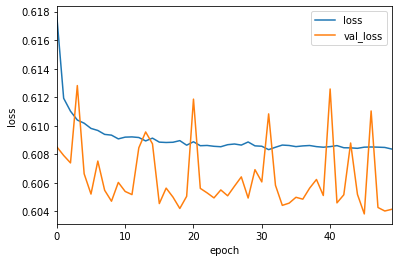

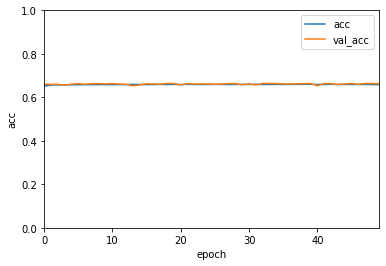

In [31]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [34]:
# 予測
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [37]:
y_test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [40]:
# 汎化性能の確認
y_test_check = y_df_test.values
calc_general_perf(y_pred, y_test_check)

正解率 = 66.252
適合率(precision) = 59.353
再現率(recall) = 50.325
F1値(F1-score) = 54.467


# 各分類手法の汎化性能まとめ
DAY2のロジスティック回帰と比較して、DAY3で新たに採用した分類手法の汎化性能はわずかに向上している。

| 分類手法 | 正解率 | 適合率 | 再現率 | F1値 |
| :---: | :---: | :--- | :---: | :---: |
| ロジスティック回帰 | 65.439 | 59.945 | 41.696 | 49.182 |
| 決定木 | 65.709 | 59.601 | 45.030 | 51.301 |
| ランダムフォレスト | 67.028 | 61.789 | 46.638 | 53.155 |
| アダブースト | 66.500 | 59.912 | 49.806 | 54.806 |
| 全結合ニューラルネットワーク | 66.252 | 59.353 | 50.325 | 54.467 |